In [1]:
from qml_essentials.qoc import QOC
import csv
import matplotlib.pyplot as plt

qoc = QOC()
n_loops = qoc.n_loops
n_steps = qoc.n_steps
n_samples = qoc.n_samples

# optimize(gate="all", loops=5, make_log=True)

qoc_results = {}
with open("../qml_essentials/qoc_results.csv", "r") as f:
    reader = csv.reader(f)

    for row in reader:
        qoc_results[row[0]] = [float(x) for x in row[2:]]

qoc_logs = {}
with open("../qml_essentials/qoc_logs.csv", "r") as f:
    reader = csv.DictReader(f)
    qoc_logs = {field: [] for field in reader.fieldnames}

    for row in reader:
        for field in reader.fieldnames:
            val = float(row[field])
            qoc_logs[field].append(val)


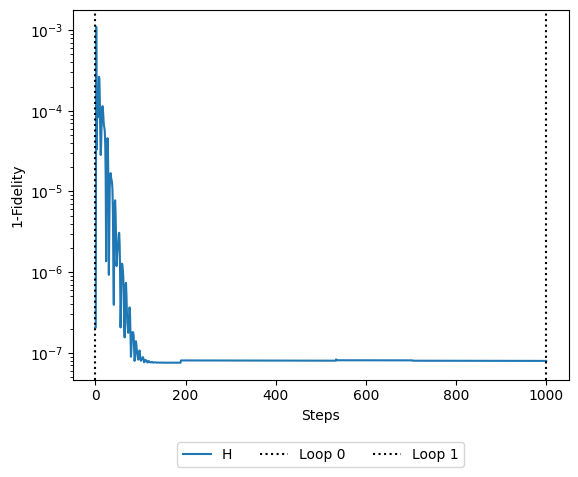

In [2]:
fig, ax = plt.subplots()

# for each gate, plot the fidelity
for gate, fidelities in qoc_logs.items():
    ax.plot(fidelities, label=gate)

for loop in range(n_loops + 1):
    plt.axvline(x=n_steps*loop, color='k', ls=':', label=f"Loop {loop}")

ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("Steps")
ax.set_ylabel("1-Fidelity")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=False, ncol=5)

plt.show()

In [6]:
from qml_essentials.ansaetze import PulseInformation
import pennylane as qml
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

gates = ["CX", "CY", "CZ"]

# PulseInformation.update_params("../qml_essentials/qoc_results.csv")

results = {}
for gate in gates:
    pulse_circuit, target_circuit = getattr(qoc, "create_" + gate)()

    dev = qml.device("default.qubit", wires=2)
    pulse_qnode = qml.QNode(pulse_circuit, dev, interface="jax")
    target_qnode = qml.QNode(target_circuit, dev, interface="jax")

    results[gate] = {"pulse": {"x": [], "y": [], "z": []}, "target": {"x": [], "y": [], "z": []}}

    ws = jnp.arange(0, 2 * jnp.pi, (2 * jnp.pi) / n_samples)
    for i, w in enumerate(ws): 
        print(f"\rSimulating {gate} gate - Parameter sweep {i+1}/{n_samples}", end="")

        res = pulse_qnode(w, PulseInformation.gate_by_name(gate).params)
        results[gate]["pulse"]["x"].append(res[0].item())
        results[gate]["pulse"]["y"].append(res[1].item())
        results[gate]["pulse"]["z"].append(res[2].item())

        res = target_qnode(w)
        results[gate]["target"]["x"].append(res[0].item())
        results[gate]["target"]["y"].append(res[1].item())
        results[gate]["target"]["z"].append(res[2].item())

    print("")

Simulating CX gate - Parameter sweep 8/8
Simulating CY gate - Parameter sweep 8/8
Simulating CZ gate - Parameter sweep 8/8


/home/debian/storage/lc3267/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/debian/storage/lc3267/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/debian/storage/lc3267/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/debian/storage/lc3267/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/debian/storage/lc3267/qml-essentials/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imag

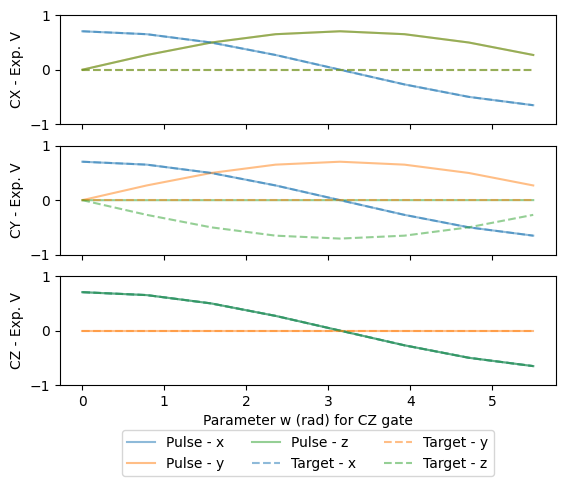

In [7]:
fig, axs = plt.subplots(len(gates), 1)

for i, gate in enumerate(gates):
    colors = iter(["C0", "C1", "C2"])
    for basis, expval in results[gate]["pulse"].items():
        axs[i].plot(ws, expval, linestyle="-", label=f"Pulse - {basis}", color=next(colors), alpha=0.5)

    colors = iter(["C0", "C1", "C2"])
    for basis, expval in results[gate]["target"].items():
        axs[i].plot(ws, expval, linestyle="--", label=f"Target - {basis}", color=next(colors), alpha=0.5)

    axs[i].set_ylabel(f"{gate} - Exp. V")
    axs[i].set_ylim(-1.0, 1.0)

    if i == len(gates) - 1:
        axs[i].set_xlabel(f"Parameter w (rad) for {gate} gate")
        axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
            fancybox=True, shadow=False, ncol=3)
    else:
        axs[i].set_xticklabels([])

plt.show()